# Классификация отзывов IMDB

## 1. Установки и импорт

In [ ]:
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 41.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, Bidirectional, LSTM, Dense, TextVectorization
from keras.utils import np_utils
from nltk.corpus import stopwords
import nltk
from collections import Counter
import seaborn as sns
import numpy as np
import os
import string
import re
import shutil  
import matplotlib.pyplot as plt

## 2. Загрузка данных IMDB movie review sentiment classification

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  31.4M      0  0:00:02  0:00:02 --:--:-- 31.4M


Посмотрим содержание папок

In [ ]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [ ]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [ ]:
!ls aclImdb/train

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


Папки содержат текстовые файлы отзывов, разделенные на положительные и отрицательные, в названиях файлов указан рейтинг отзыва.

Удалим папку unsup, а также создадим в папках train и test папки для разбиения отзывов по рейтингу, всего 8 папок (5 и 6 звезд у отзывов нет)

In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
for dir in range (1,5):
    os.mkdir(f'aclImdb/train/{dir}')
for dir in range (7,11):
    os.mkdir(f'aclImdb/train/{dir}')

In [ ]:
!ls aclImdb/train

1   2  4  8  labeledBow.feat  pos	     urls_neg.txt  urls_unsup.txt
10  3  7  9  neg	      unsupBow.feat  urls_pos.txt


In [ ]:
for dir in range (1,5):
    os.mkdir(f'aclImdb/test/{dir}')
for dir in range (7,11):
    os.mkdir(f'aclImdb/test/{dir}')
!ls aclImdb/test 

1  10  2  3  4	7  8  9  labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


Теперь расположим файлы в папках соответствующих их рейтингу и удалим папки pos, neg

In [ ]:
directory = 'aclImdb/train'
 
for root, dirs, files in os.walk(directory):
    if root == 'aclImdb/train/neg' or root== 'aclImdb/train/pos':
        for file_ in files:
            if int(file_[-5])!=0:
                dir_ = int(file_[-5])
            else:  
                dir_ = int(file_[-6:-4])

            os.rename(''.join([root,'/',file_]), f'aclImdb/train/{dir_}/{file_}')

In [ ]:
!rm -r aclImdb/train/neg
!rm -r aclImdb/train/pos

In [ ]:
!ls aclImdb/train 

1   2  4  8  labeledBow.feat  urls_neg.txt  urls_unsup.txt
10  3  7  9  unsupBow.feat    urls_pos.txt


In [ ]:
directory = 'aclImdb/test'
 
for root, dirs, files in os.walk(directory):
    if root == 'aclImdb/test/neg' or root== 'aclImdb/test/pos':
        for file_ in files:
            if int(file_[-5])!=0:
                dir_ = int(file_[-5])
            else:  
                dir_ = int(file_[-6:-4])

            os.rename(''.join([root,'/',file_]), f'aclImdb/test/{dir_}/{file_}')



In [ ]:
!rm -r aclImdb/test/neg
!rm -r aclImdb/test/pos

In [ ]:
!ls aclImdb/test

1  10  2  3  4	7  8  9  labeledBow.feat  urls_neg.txt	urls_pos.txt


Используя функцию text_dataset_from_directory создадим train, valid, test датасеты.

In [ ]:
batch_size = 32
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 8 classes.
Using 20000 files for training.
Found 25000 files belonging to 8 classes.
Using 5000 files for validation.
Found 25000 files belonging to 8 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


Посмотрим на соответствия меток и рейтингов, составим словарь

In [ ]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to 1
Label 1 corresponds to 10
Label 2 corresponds to 2
Label 3 corresponds to 3
Label 4 corresponds to 4
Label 5 corresponds to 7
Label 6 corresponds to 8
Label 7 corresponds to 9


In [ ]:
labels_dict={0:1, 1:10, 2:2, 3:3, 4:4, 5:7, 6:8, 7:9}

Посмотрим на несколько отзывов

In [ ]:
for comments, labels in raw_train_ds.take(1):
    for i in range(5):
        print(comments.numpy()[i])
        print(labels.numpy()[i])

b"Good western filmed in the rocky Arizona wilds. Lots of tough guys throughout; Cobern's character seemed to rock back and forth between a raging psycho and a laid back type. Several holes appeared in the picture, but not enough to offset it being exciting and worth seeing. One really dumb scene shows Heston emptying .45 cases of their powder and collecting it in a sack for the purpose of starting a fire. A. To gather that much gunpowder he would have needed a pack mule to carry the ammo. B. The grass was obviously dry: why not just drop a match on it and let 'er rip?"
5
b"This film has great acting, great photography and a very strong story line that really makes you think about who you are, how you define yourself, how you fit in, whether you accept to play a role or break free... There already are excellent comments dealing with these aspects. I want to comment on the formal setting of the film. Basically, it's two people on a roof. There is unity of place and time, with 2 protagon

## 3. Подготовка данных


Сначала проведем отчистку и стандартизацию отзывов

In [ ]:
stops = nltk.download('stopwords')
stops=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<AxesSubplot:>

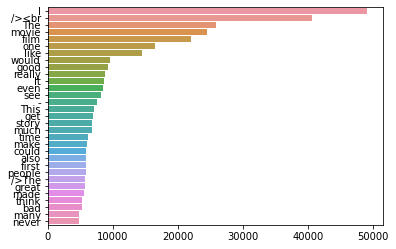

In [ ]:
# построим график самых повторяющихся слов без стоп-слов
corpus=[]
for comments, _ in raw_train_ds:
      for x in comments.numpy():
        for i in str(x).split():
          corpus.append(i)
counter=Counter(corpus)
most_common=counter.most_common()
x, y = [], []
for word,count in most_common[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

In [ ]:
# удалим стоп-слова
def remove_stopwords(text, label):
    text = tf.strings.regex_replace(text, r'\b(' + r'|'.join(stops) + r')\b\s*',"")
    return text, label

raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_stopwords), raw_val_ds.map(remove_stopwords), raw_test_ds.map(remove_stopwords)

In [ ]:
# удалим теги
def remove_tags(text, label):
    return tf.strings.regex_replace(text, "<br />", " "), label

raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_tags), raw_val_ds.map(remove_tags), raw_test_ds.map(remove_tags)

In [ ]:
# удалим пунктуацию и переведем слова в нижний регистр
def remove_punctuations(text, label):
    text = tf.strings.lower(text)
    return tf.strings.regex_replace(text, '[^\w\s]', ''), label

# удалим оставшийся HTML синтаксис
def remove_html(text, label):
    return tf.strings.regex_replace(text, '<.*?>', ''), label

# удалим URL
def remove_url(text, label):
    return tf.strings.regex_replace(text, 'https://\S+|www\.\S+', ''), label

# удалим эмодзи (если они есть)
def remove_emoji(text, label):
    text = tf.strings.regex_replace(text, "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", '')
    return tf.strings.regex_replace(text, 'https://\S+|www\.\S+', ''), label

raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_punctuations), raw_val_ds.map(remove_punctuations), raw_test_ds.map(remove_punctuations)
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_html), raw_val_ds.map(remove_html), raw_test_ds.map(remove_html)
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_url), raw_val_ds.map(remove_url), raw_test_ds.map(remove_url)
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_emoji), raw_val_ds.map(remove_emoji), raw_test_ds.map(remove_emoji)

In [ ]:
# расшифруем сокращенные выражения
def remove_abb(text, label):
    text = tf.strings.regex_replace(text, "he's", "he is")
    text = tf.strings.regex_replace(text, "there's", "there is")
    text = tf.strings.regex_replace(text, "We're", "We are")
    text = tf.strings.regex_replace(text, "That's", "That is")
    text = tf.strings.regex_replace(text, "won't", "will not")
    text = tf.strings.regex_replace(text, "they're", "they are")
    text = tf.strings.regex_replace(text, "Can't", "Cannot")
    text = tf.strings.regex_replace(text, "wasn't", "was not")
    text = tf.strings.regex_replace(text, "don\x89Ûªt", "do not")
    text = tf.strings.regex_replace(text, "aren't", "are not")
    text = tf.strings.regex_replace(text, "isn't", "is not")
    text = tf.strings.regex_replace(text, "What's", "What is")
    text = tf.strings.regex_replace(text, "haven't", "have not")
    text = tf.strings.regex_replace(text, "hasn't", "has not")
    text = tf.strings.regex_replace(text, "There's", "There is")
    text = tf.strings.regex_replace(text, "He's", "He is")
    text = tf.strings.regex_replace(text, "It's", "It is")
    text = tf.strings.regex_replace(text, "You're", "You are")
    text = tf.strings.regex_replace(text, "I'M", "I am")
    text = tf.strings.regex_replace(text, "shouldn't", "should not")
    text = tf.strings.regex_replace(text, "wouldn't", "would not")
    text = tf.strings.regex_replace(text, "i'm", "I am")
    text = tf.strings.regex_replace(text, "I\x89Ûªm", "I am")
    text = tf.strings.regex_replace(text, "I'm", "I am")
    text = tf.strings.regex_replace(text, "Isn't", "is not")
    text = tf.strings.regex_replace(text, "Here's", "Here is")
    text = tf.strings.regex_replace(text, "you've", "you have")
    text = tf.strings.regex_replace(text, "you\x89Ûªve", "you have")
    text = tf.strings.regex_replace(text, "we're", "we are")
    text = tf.strings.regex_replace(text, "what's", "what is")
    text = tf.strings.regex_replace(text, "couldn't", "could not")
    text = tf.strings.regex_replace(text, "we've", "we have")
    text = tf.strings.regex_replace(text, "it\x89Ûªs", "it is")
    text = tf.strings.regex_replace(text, "doesn\x89Ûªt", "does not")
    text = tf.strings.regex_replace(text, "It\x89Ûªs", "It is")
    text = tf.strings.regex_replace(text, "Here\x89Ûªs", "Here is")
    text = tf.strings.regex_replace(text, "who's", "who is")
    text = tf.strings.regex_replace(text, "I\x89Ûªve", "I have")
    text = tf.strings.regex_replace(text, "y'all", "you all")
    text = tf.strings.regex_replace(text, "can\x89Ûªt", "cannot")
    text = tf.strings.regex_replace(text, "would've", "would have")
    text = tf.strings.regex_replace(text, "it'll", "it will")
    text = tf.strings.regex_replace(text, "we'll", "we will")
    text = tf.strings.regex_replace(text, "wouldn\x89Ûªt", "would not")
    text = tf.strings.regex_replace(text, "We've", "We have")
    text = tf.strings.regex_replace(text, "he'll", "he will")
    text = tf.strings.regex_replace(text, "Y'all", "You all")
    text = tf.strings.regex_replace(text, "Weren't", "Were not")
    text = tf.strings.regex_replace(text, "Didn't", "Did not")
    text = tf.strings.regex_replace(text, "they'll", "they will")
    text = tf.strings.regex_replace(text, "they'd", "they would")
    text = tf.strings.regex_replace(text, "DON'T", "DO NOT")
    text = tf.strings.regex_replace(text, "That\x89Ûªs", "That is")
    text = tf.strings.regex_replace(text, "they've", "they have")
    text = tf.strings.regex_replace(text, "i'd", "I would")
    text = tf.strings.regex_replace(text, "should've", "should have")
    text = tf.strings.regex_replace(text, "You\x89Ûªre", "You are")
    text = tf.strings.regex_replace(text, "where's", "where is")
    text = tf.strings.regex_replace(text, "Don\x89Ûªt", "Do not")
    text = tf.strings.regex_replace(text, "we'd", "we would")
    text = tf.strings.regex_replace(text, "i'll", "I will")
    text = tf.strings.regex_replace(text, "weren't", "were not")
    text = tf.strings.regex_replace(text, "They're", "They are")
    text = tf.strings.regex_replace(text, "Can\x89Ûªt", "Cannot")
    text = tf.strings.regex_replace(text, "you\x89Ûªll", "you will")
    text = tf.strings.regex_replace(text, "I\x89Ûªd", "I would")
    text = tf.strings.regex_replace(text, "let's", "let us")
    text = tf.strings.regex_replace(text, "it's", "it is")
    text = tf.strings.regex_replace(text, "can't", "cannot")
    text = tf.strings.regex_replace(text, "don't", "do not")
    text = tf.strings.regex_replace(text, "you're", "you are")
    text = tf.strings.regex_replace(text, "i've", "I have")
    text = tf.strings.regex_replace(text, "that's", "that is")
    text = tf.strings.regex_replace(text, "i'll", "I will")
    text = tf.strings.regex_replace(text, "doesn't", "does not")
    text = tf.strings.regex_replace(text, "i'd", "I would")
    text = tf.strings.regex_replace(text, "didn't", "did not")
    text = tf.strings.regex_replace(text, "ain't", "am not")
    text = tf.strings.regex_replace(text, "you'll", "you will")
    text = tf.strings.regex_replace(text, "I've", "I have")
    text = tf.strings.regex_replace(text, "Don't", "do not")
    text = tf.strings.regex_replace(text, "I'll", "I will")
    text = tf.strings.regex_replace(text, "I'd", "I would")
    text = tf.strings.regex_replace(text, "Let's", "Let us")
    text = tf.strings.regex_replace(text, "you'd", "You would")
    text = tf.strings.regex_replace(text, "It's", "It is")
    text = tf.strings.regex_replace(text, "Ain't", "am not")
    text = tf.strings.regex_replace(text, "Haven't", "Have not")
    text = tf.strings.regex_replace(text, "Could've", "Could have")
    text = tf.strings.regex_replace(text, "youve", "you have")  
    text = tf.strings.regex_replace(text, "donå«t", "do not") 
    return text, label  
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_abb), raw_val_ds.map(remove_abb), raw_test_ds.map(remove_abb)

<AxesSubplot:>

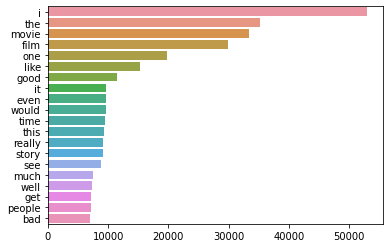

In [ ]:
# повторно построим график самых повторяющихся слов
corpus=[]
for comments, _ in raw_train_ds:
      for x in comments.numpy():
        for i in str(x).split():
          corpus.append(i)
counter=Counter(corpus)
most_common=counter.most_common()
x, y = [], []
for word,count in most_common[:20]:
    x.append(word)
    y.append(count)
sns.barplot(x=y,y=x)

После очистки отзывов векторизуем их при помощи tf.keras.layers.TextVectorization

In [ ]:
# Константы модели
max_features = 20000
embedding_dim = 128
sequence_length = 500

# слой векторизации
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# адаптируем vectorize_layer к нашим отзывам
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
# функция векторизации для векторизации датасета
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Векторизуем данные
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## 4. Построение простых моделей

Здесь выберем несколько моделей и построим их.
Так как классов 8, то и результирующий слой будет из 8 нейронов.

In [ ]:
# Conv1D модель
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(8, name="predictions")(x)

model_conv = tf.keras.Model(inputs, predictions)
model_conv.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [ ]:
# LSTM 2 слоя
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)

x = layers.LSTM(128, return_sequences=True, return_state=False)(x)
x = layers.LSTM(256, return_sequences=True, return_state=False)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(8, name="predictions")(x)

model_LSTM2 = tf.keras.Model(inputs, predictions)
model_LSTM2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [ ]:
# Bidirectional LSTM
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)

x = layers.Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = layers.AveragePooling1D(pool_size = 2)(x)
x = layers.Bidirectional(LSTM(200, dropout = 0.5))(x)

predictions = tf.keras.layers.Dense(8, name="predictions")(x)

model_bi = tf.keras.Model(inputs, predictions)
model_bi.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [ ]:
# LSTM модель
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs)

x = layers.Bidirectional(LSTM(75, dropout = 0.1))(x)
predictions = tf.keras.layers.Dense(8, name="predictions")(x)

model_LSTM = tf.keras.Model(inputs, predictions)
model_LSTM.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

## 5. Тренировка моделей

In [ ]:
epochs = 15

model_conv.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
625/625 [==============================] - 19s 15ms/step - loss: 1.8661 - accuracy: 0.2840 - val_loss: 1.6135 - val_accuracy: 0.3646
Epoch 2/15
625/625 [==============================] - 6s 9ms/step - loss: 1.4795 - accuracy: 0.4161 - val_loss: 1.5278 - val_accuracy: 0.4048
Epoch 3/15
625/625 [==============================] - 6s 9ms/step - loss: 1.2202 - accuracy: 0.5059 - val_loss: 1.6473 - val_accuracy: 0.3928
Epoch 4/15
625/625 [==============================] - 5s 8ms/step - loss: 1.0267 - accuracy: 0.5798 - val_loss: 1.8559 - val_accuracy: 0.3630
Epoch 5/15
625/625 [==============================] - 5s 8ms/step - loss: 0.8792 - accuracy: 0.6341 - val_loss: 1.9184 - val_accuracy: 0.3614
Epoch 6/15
625/625 [==============================] - 6s 9ms/step - loss: 0.7621 - accuracy: 0.6793 - val_loss: 2.3297 - val_accuracy: 0.3556
Epoch 7/15
625/625 [==============================] - 5s 9ms/step - loss: 0.6850 - accuracy: 0.7161 - val_loss: 2.5474 - val_accuracy: 0.3546
Epoc

In [ ]:
epochs = 15

model_LSTM2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
625/625 [==============================] - 30s 48ms/step - loss: 0.0718 - accuracy: 0.9771 - val_loss: 4.4851 - val_accuracy: 0.3636
Epoch 2/15
625/625 [==============================] - 30s 48ms/step - loss: 0.0547 - accuracy: 0.9817 - val_loss: 4.7505 - val_accuracy: 0.3604
Epoch 3/15
625/625 [==============================] - 30s 48ms/step - loss: 0.0463 - accuracy: 0.9843 - val_loss: 5.0044 - val_accuracy: 0.3656
Epoch 4/15
625/625 [==============================] - 30s 48ms/step - loss: 0.0439 - accuracy: 0.9864 - val_loss: 5.5565 - val_accuracy: 0.3476
Epoch 5/15
625/625 [==============================] - 30s 47ms/step - loss: 0.0412 - accuracy: 0.9870 - val_loss: 5.8506 - val_accuracy: 0.3376
Epoch 6/15
625/625 [==============================] - 30s 48ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 5.7490 - val_accuracy: 0.3508
Epoch 7/15
625/625 [==============================] - 30s 48ms/step - loss: 0.0349 - accuracy: 0.9885 - val_loss: 5.6201 - val_accuracy:

In [ ]:
epochs = 15

model_bi.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
625/625 [==============================] - 26s 31ms/step - loss: 1.7770 - accuracy: 0.3209 - val_loss: 1.5678 - val_accuracy: 0.3786
Epoch 2/15
625/625 [==============================] - 19s 31ms/step - loss: 1.4233 - accuracy: 0.4347 - val_loss: 1.5837 - val_accuracy: 0.3844
Epoch 3/15
625/625 [==============================] - 18s 29ms/step - loss: 1.2464 - accuracy: 0.4967 - val_loss: 1.6215 - val_accuracy: 0.4034
Epoch 4/15
625/625 [==============================] - 18s 30ms/step - loss: 1.1273 - accuracy: 0.5403 - val_loss: 1.7447 - val_accuracy: 0.3428
Epoch 5/15
625/625 [==============================] - 18s 29ms/step - loss: 1.0195 - accuracy: 0.5843 - val_loss: 1.8704 - val_accuracy: 0.3498
Epoch 6/15
625/625 [==============================] - 18s 29ms/step - loss: 0.9142 - accuracy: 0.6263 - val_loss: 2.0119 - val_accuracy: 0.3434
Epoch 7/15
625/625 [==============================] - 18s 29ms/step - loss: 0.8320 - accuracy: 0.6618 - val_loss: 2.0662 - val_accuracy:

In [ ]:
epochs = 15

model_LSTM.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
625/625 [==============================] - 31s 43ms/step - loss: 1.6991 - accuracy: 0.3490 - val_loss: 1.6433 - val_accuracy: 0.3716
Epoch 2/15
625/625 [==============================] - 25s 39ms/step - loss: 1.3888 - accuracy: 0.4534 - val_loss: 1.5814 - val_accuracy: 0.3806
Epoch 3/15
625/625 [==============================] - 25s 40ms/step - loss: 1.2193 - accuracy: 0.5178 - val_loss: 1.7299 - val_accuracy: 0.3512
Epoch 4/15
625/625 [==============================] - 25s 40ms/step - loss: 1.0600 - accuracy: 0.5882 - val_loss: 1.8084 - val_accuracy: 0.3446
Epoch 5/15
625/625 [==============================] - 24s 39ms/step - loss: 0.8776 - accuracy: 0.6742 - val_loss: 2.0056 - val_accuracy: 0.3162
Epoch 6/15
625/625 [==============================] - 25s 40ms/step - loss: 0.6862 - accuracy: 0.7574 - val_loss: 2.3052 - val_accuracy: 0.3234
Epoch 7/15
625/625 [==============================] - 25s 40ms/step - loss: 0.5345 - accuracy: 0.8218 - val_loss: 2.5206 - val_accuracy:

Можной увидеть что для всех моделей с каждой эпохой падает val_accuracy и увеличивается val_loss, при обратном эффекте для accuracy и loss, что говорит о переобучении моделей.

## 6. Оценка моделей

In [ ]:
model_conv.evaluate(test_ds)

782/782 [==============================] - 6s 7ms/step - loss: 4.4273 - accuracy: 0.3440


[4.427250862121582, 0.3439599871635437]

In [ ]:
model_LSTM2.evaluate(test_ds)

782/782 [==============================] - 15s 19ms/step - loss: 6.1816 - accuracy: 0.3658


[6.181572437286377, 0.36583998799324036]

In [ ]:
model_bi.evaluate(test_ds)

782/782 [==============================] - 9s 12ms/step - loss: 3.1960 - accuracy: 0.3191


[3.195984125137329, 0.31911998987197876]

In [ ]:
model_LSTM.evaluate(test_ds)

782/782 [==============================] - 12s 15ms/step - loss: 4.3684 - accuracy: 0.3100


[4.368371486663818, 0.3100000023841858]

Самая высокая точность оказалось у LSTM2 модели - 0.3658, но у нее и самая большая потеря 6.1816
При всем этом точность всех моделей оказывается сравнительно маленькой ≈ 0.35, 
что говорито необходимости доработки, хотя это и выше случайного предсказания в 0.125.

## 7. Создание end-to-end моделей и сохранение

Для удобства развертывания сохраним end-to-end модели.

In [ ]:
#LSTM2 end-to-end 
inputs = tf.keras.Input(shape=(1,), dtype="string")
indices = vectorize_layer(inputs)
outputs = model_LSTM2(indices)

end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"]
)

end_to_end_model.evaluate(raw_test_ds)

782/782 [==============================] - 20s 24ms/step - loss: 6.5575 - accuracy: 0.3658


[6.557531833648682, 0.36583998799324036]

In [ ]:
end_to_end_model.save("end_to_end_model") #LSTM2 model

In [ ]:
reconstructed_model = tf.keras.models.load_model('end_to_end_model') #LSTM2 model

In [ ]:
shutil.make_archive('end_to_end_model', 'zip', 'end_to_end_model')

In [ ]:
#conv end-to-end 
inputs = tf.keras.Input(shape=(1,), dtype="string")
indices = vectorize_layer(inputs)
outputs = model_conv(indices)

end_to_end_model_conv = tf.keras.Model(inputs, outputs)
end_to_end_model_conv.compile(
    loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"]
)

In [ ]:
end_to_end_model_conv.save("end_to_end_model_conv") #conv model

In [ ]:
reconstructed_model = tf.keras.models.load_model('end_to_end_model_conv') #conv model

In [ ]:
shutil.make_archive('end_to_end_model_conv', 'zip', 'end_to_end_model_conv')

'/content/end_to_end_model_conv.zip'

In [ ]:
# bi end-to-end
inputs = tf.keras.Input(shape=(1,), dtype="string")
indices = vectorize_layer(inputs)
outputs = model_bi(indices)

end_to_end_model_bi = tf.keras.Model(inputs, outputs)
end_to_end_model_bi.compile(
    loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"]
)

In [ ]:
end_to_end_model_bi.save("end_to_end_model_bi") #bi model

In [ ]:
reconstructed_model = tf.keras.models.load_model('end_to_end_model_bi') #bi model

In [ ]:
shutil.make_archive('end_to_end_model_bi', 'zip', 'end_to_end_model_bi')

'/content/end_to_end_model_bi.zip'

In [ ]:
# LSTM end-to-end
inputs = tf.keras.Input(shape=(1,), dtype="string")
indices = vectorize_layer(inputs)
outputs = model_LSTM(indices)

end_to_end_model_LSTM = tf.keras.Model(inputs, outputs)
end_to_end_model_LSTM.compile(
    loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"]
)

In [ ]:
end_to_end_model_LSTM.save("end_to_end_model_LSTM") #LSTM model

In [ ]:
reconstructed_model = tf.keras.models.load_model('end_to_end_model_LSTM') #LSTM model

In [ ]:
shutil.make_archive('end_to_end_model_LSTM', 'zip', 'end_to_end_model_LSTM')

'/content/end_to_end_model_LSTM.zip'

# 8. Проверка предсказания модели
Здесь проверим работоспособность LSTM2 модели

In [ ]:
# текст
text_list = ['i like it!',
        'very good film',
        "bad film, don't like not interesting"]

In [ ]:
# функция очистки
def clean_text(text):
  text, _ = remove_stopwords(text, 1)
  text, _ = remove_tags(text, 1)
  text, _ = remove_punctuations(text, 1)
  text, _ = remove_html(text, 1)
  text, _ = remove_url(text, 1)
  text, _ = remove_abb(text, 1)
  return bytes.decode(text.numpy())

In [ ]:
# отзывы после отчистки
inp = list(map(clean_text, text_list))
inp

['like ', 'good film', 'bad film like interesting']

In [ ]:
# предсказание на неочищенных отзывах
pred = end_to_end_model.predict(['good very good film'])

1/1 [==============================] - 0s 54ms/step


In [ ]:
for i in pred:
  print('Rating:', labels_dict[int(tf.math.argmax(i))])

Rating: 9


# 9. Выводы простых моделей.
Как и говорилось ранее точность моделей получилась низкая, для ее дальнейшего улучшения предлагается использовать: </br>
дополнительные данные с рейтингом 5 и 6 звезд,
анализ n-грамм, удалять не все стоп-слова, использовать word2vec векторизацию, применить предобученную модель BERT. </br>
Помимо этого считаю необходимым использовать регрессию вместо классификации, так как accuracy не дает понимания близости предсказанного отзыва к правильному (например ошибка в одну, пол звезды), что можно отследить используя MSE/RMSE. 

## 10. Использование предобученной BERT модели
Здесь мы изменим только модель и воспользуемся возможностями предобученной модели BERT построенной на трансформере

Установка и импорт дополнительных библиотек

In [ ]:
!pip install tensorflow==2.11.0

In [ ]:
!pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 28.9 MB/s eta 0:00:00


In [ ]:
!pip install -q tf-models-official==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

Воспользуемся вариантом talking-heads_base encoder и соотетствующим ему препроцессоре

In [ ]:
bert_model_name = 'talking-heads_base'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

Проверим как действуют препроцессор и энкодер

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.04164823 -0.16072084 -0.16938786 -0.14112622 -0.4564236  -0.3629583
  0.00949449 -0.38472784 -0.37134975  0.3133377  -0.4287782  -0.10479412]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.13529712  1.0244596   0.3802941  ... -0.37565243 -1.1732501
  -0.28629497]
 [ 0.5394494   0.00559767 -0.4814456  ... -0.13281812 -0.1544642
   0.08407846]
 [-0.17764494  0.42034125 -0.85463417 ... -0.55584425  0.07440345
  -0.12776999]
 ...
 [-0.3672859  -1.3684146  -1.4262097  ... -0.0726788  -0.12514548
   0.37932378]
 [-0.390374   -1.3010331  -1.4451113  ...  0.05920417 -0.11835855
   0.3479999 ]
 [ 0.4895529  -1.0587397  -1.2525872  ... -0.7043437   0.14188947
   0.2320122 ]]


Построим модель talking-heads

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(8, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
bert_model = build_classifier_model()
bert_raw_result = bert_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor(
[[0.06446742 0.1159858  0.20228304 0.14269292 0.14144097 0.16322187
  0.10113025 0.06877775]], shape=(1, 8), dtype=float32)


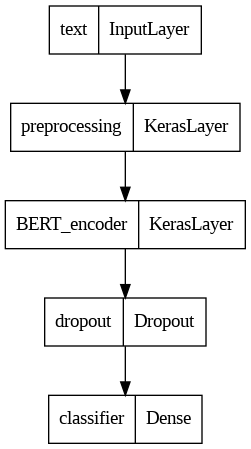

In [ ]:
tf.keras.utils.plot_model(bert_model)

Скомпилируем модель задав гиперпараметры и обучим ее

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
bert_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=["accuracy"])

In [ ]:
history = bert_model.fit(raw_train_ds,
                               validation_data=raw_val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 867s 1s/step - loss: 1.6717 - accuracy: 0.3474 - val_loss: 1.4517 - val_accuracy: 0.4274
Epoch 2/5
625/625 [==============================] - 831s 1s/step - loss: 1.2977 - accuracy: 0.4780 - val_loss: 1.4844 - val_accuracy: 0.4468
Epoch 3/5
625/625 [==============================] - 845s 1s/step - loss: 1.0171 - accuracy: 0.5914 - val_loss: 1.6551 - val_accuracy: 0.4270
Epoch 4/5
625/625 [==============================] - 845s 1s/step - loss: 0.7553 - accuracy: 0.7054 - val_loss: 1.9156 - val_accuracy: 0.4148
Epoch 5/5
625/625 [==============================] - 832s 1s/step - loss: 0.5727 - accuracy: 0.7839 - val_loss: 2.0963 - val_accuracy: 0.4186


При 5 эпохах модель как и предыдущие начинает переобучаться. </br>
Оценим модель


In [ ]:
loss, accuracy = bert_model.evaluate(raw_test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 101s 128ms/step - loss: 1.6138 - accuracy: 0.3978
Loss: 1.6138099431991577
Accuracy: 0.3978399932384491


In [ ]:
bert_model_json = bert_model.to_json()
with open("bert_model.json", "w") as json_file:
    json_file.write(bert_model_json)
# serialize weights to HDF5
bert_model.save_weights("bert_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import pickle

In [ ]:
pickle.dump(bert_model, open('bert_model.pkl', 'wb'))

# 11. Вывод. </br>
Изменение модели на предобученную модель BERT улучшило accuracy на ≈ 0.05 до 0.4, что сравнимо мало, поэтому необходимо производить дополнительную подготовку данных, а также добавить в датасет отзывы 5 и 6 звезд. 